In [1]:
image_file2 ='/orange/adamginsburg/ALMA-IMF/RestructuredImagingResults/W51-IRS2/B3/cleanest/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_fin.image.tt0.pbcor.fits'

In [2]:
from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy import visualization
from astropy.visualization import simple_norm

In [3]:
almaimf_b3 = '/orange/adamginsburg/ALMA_IMF/RestructuredImagingResults/W51-IRS2/B3/cleanest/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits'
fh = fits.open(almaimf_b3)
ww = WCS(fh[0].header)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
%matplotlib inline
import pylab as pl
pl.style.use('default')
pl.rcParams['font.size'] = 16
import copy
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
import numpy as np

In [5]:
fh[0].data.shape

(1, 1, 3840, 3840)

In [6]:
from astropy import units as u
from astropy import coordinates
from astropy.stats import mad_std
from astropy.visualization import simple_norm
import astropy.visualization
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import radio_beam


def make_scalebar(ax, left_side, length, color='w', linestyle='-', label='',
                  fontsize=12, text_offset=0.1*u.arcsec):
    axlims = ax.axis()
    lines = ax.plot(u.Quantity([left_side.ra, left_side.ra-length]),
                    u.Quantity([left_side.dec]*2),
                    color=color, linestyle=linestyle, marker=None,
                    transform=ax.get_transform('fk5'),
                   )
    txt = ax.text((left_side.ra-length/2).to(u.deg).value,
                  (left_side.dec+text_offset).to(u.deg).value,
                  label,
                  verticalalignment='bottom',
                  horizontalalignment='center',
                  transform=ax.get_transform('fk5'),
                  color=color,
                  fontsize=fontsize,
                 )
    ax.axis(axlims)
    return lines,txt



def make_zoom(filename, zoom_parameters,
              overview_vis_pars={'max_percent':99.5, 'min_percent':0.5, 'stretch':'linear'},
              overview_cmap='gray_r',
              inset_cmap='inferno',
              main_zoombox=None,
              scalebar_loc=(0.1,0.1),
              scalebar_length=0.1*u.pc,
              beam_loc=(0.05, 0.05),
              nsigma_asinh=5,
              nsigma_max=10,
              nticks_inset=7,
              fontsize=20,
              tick_fontsize=16,
              distance=8.5*u.kpc
             ):

    fh = fits.open(filename)
    img = fh[0].data
    ww = WCS(fh[0].header)
    
    # cut out the minimal region that has data in it
    lbx,lby = np.argmax(np.any(notnan, axis=0)), np.argmax(np.any(notnan, axis=1))
    rtx,rty = notnan.shape[1] - np.argmax(np.any(notnan[::-1,::-1], axis=0)), notnan.shape[0] - np.argmax(np.any(notnan[::-1,::-1], axis=1))
    
    img = img[lby:rty, lbx:rtx]
    ww = ww[lby:rty, lbx:rtx]
    
    radesys = ww.wcs.radesys.upper()

    fig = pl.figure(1, figsize=(10,10))
    fig.clf()
    ax = fig.add_subplot(projection=ww.celestial)

    norm = simple_norm(img, **overview_vis_pars)

    img[img==0] = np.nan
    mad = mad_std(img, ignore_nan=True)

    if hasattr(norm.stretch, 'a') and nsigma_asinh is not None:
        norm.vmax = (np.nanmedian(img) + nsigma_max*mad)
        a_point = (np.nanmedian(img) + nsigma_asinh*mad) / norm.vmax
        norm.stretch.a = a_point
        print(f"numbers for norm: {np.nanmedian(img), nsigma_asinh, mad, nsigma_asinh*mad, norm.vmax, a_point}")

    im = ax.imshow(img, cmap=overview_cmap, norm=norm)

    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticks(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticks(exclude_overlapping=True)


    for zp in zoom_parameters:

        xl,xr = zp['xl'], zp['xr']
        yl,yu = zp['yl'], zp['yu']
        slc = [slice(yl,yu), slice(xl,xr)]
        axins = inset_axes(ax, **zp['inset_pars'],
                           axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                           axes_kwargs=dict(wcs=ww.celestial))

        norm2 = simple_norm(img, **zp['vis_pars'])

        inset_cm = copy.copy(pl.cm.get_cmap(inset_cmap))
        inset_cm.set_bad(inset_cm(0))

        im_ins = axins.imshow(img[slc], extent=[xl,xr,yl,yu], cmap=inset_cm, norm=norm2)
        mark_inset(parent_axes=ax, inset_axes=axins,
                   fc="none", ec="b", **zp['mark_inset_pars'])
        ra = axins.coords['ra']
        dec = axins.coords['dec']
        axins.set_xticklabels([])
        axins.set_yticklabels([])
        axins.xaxis.set_visible(False)
        axins.yaxis.set_visible(False)
        ra.set_ticks_visible(False)
        dec.set_ticks_visible(False)
        ra.set_axislabel('')
        dec.set_axislabel('')
        ra.ticklabels.set_visible(False)
        dec.ticklabels.set_visible(False)

        caxins = inset_axes(axins,
                 width="5%", # width = 10% of parent_bbox width
                 height="100%", # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

        cbins = pl.colorbar(mappable=im_ins, cax=caxins)
        cbins.ax.tick_params(labelsize=tick_fontsize)
        cbins.set_label(f"S$_\\nu$ [Jy beam$^{-1}$]", fontsize=fontsize)

        if 'tick_locs' in zp:
            cbins.set_ticks(zp['tick_locs'])
            if 'tick_labels' in zp:
                cbins.set_ticklabels(zp['tick_labels'])
        elif 'asinh' in str(norm2.stretch).lower():
            rounded_loc, rounded = determine_asinh_ticklocs(norm2.vmin, norm2.vmax, nticks=nticks_inset)
            cbins.set_ticks(rounded_loc)
            cbins.set_ticklabels(rounded)
        elif'log' in str(norm2.stretch).lower():
            if norm2.vmin > 0:
                rounded_loc, rounded = determine_asinh_ticklocs(norm2.vmin, norm2.vmax, nticks=nticks_inset, rms=mad, stretch='log')
                cbins.set_ticks(rounded_loc)
                cbins.set_ticklabels(rounded)
            else:
                ticks = cbins.get_ticks()
                newticks = [norm2.vmin] + list(ticks)
                newticks = [norm2.vmin, 0,] + list(np.geomspace(mad, norm2.vmax, 4))
                print(f"ticks={ticks}, newticks={newticks}, mad={mad}, vmin={norm2.vmin}")
                cbins.set_ticks(newticks)

    if main_zoombox:
        ax.axis(main_zoombox)

    divider = make_axes_locatable(ax)
    cax1 = fig.add_axes([ax.get_position().x1+0.01,
                         ax.get_position().y0,
                         0.02,
                         ax.get_position().height])
    cb1 = pl.colorbar(mappable=im, cax=cax1)
    cb1.ax.tick_params(labelsize=tick_fontsize)
    cb1.set_label(f"S$_\\nu$ [Jy beam$^{-1}$]", fontsize=fontsize)
    pl.setp(cb1.ax.yaxis.get_label(), backgroundcolor="white")

    left_side = coordinates.SkyCoord(*ww.celestial.wcs_pix2world(scalebar_loc[1]*img.shape[1],
                                                                        scalebar_loc[0]*img.shape[0], 0)*u.deg, frame='fk5')
    length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
    make_scalebar(ax, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
                  text_offset=0.5*u.arcsec, fontsize=fontsize)

    beam = radio_beam.Beam.from_fits_header(fh[0].header)
    ell = beam.ellipse_to_plot(beam_loc[1]*img.shape[1], beam_loc[0]*img.shape[0], pixscale=ww.celestial.pixel_scale_matrix[1,1]*u.deg)
    ax.add_patch(ell)

In [7]:
from spectral_cube import SpectralCube

In [8]:
w51irs2 = SpectralCube.read('/orange/adamginsburg/w51/2017.1.00293.S/may2021_imaging/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0', format='casa_image')
w51irs2
ww_lb = w51irs2[0].wcs
im4 = w51irs2[0].value

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [9]:
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
from matplotlib.transforms import Bbox

def mark_inset_otherdata(axins, parent_ax, bl, tr, loc1, loc2, edgecolor='b'):
        blt = bl.transform_to(parent_ax.wcs.wcs.radesys.lower())
        trt = tr.transform_to(parent_ax.wcs.wcs.radesys.lower())
        (rx1,ry1),(rx2,ry2) = (parent_ax.wcs.wcs_world2pix([[blt.ra.deg,
                                                             blt.dec.deg]],0)[0],
                               parent_ax.wcs.wcs_world2pix([[trt.ra.deg,
                                                             trt.dec.deg]],0)[0]
                              )
        bbox = Bbox(np.array([(rx1,ry1),(rx2,ry2)]))
        rect = TransformedBbox(bbox, parent_ax.transData)

        markinkwargs = dict(fc='none', ec=edgecolor)

        pp = BboxPatch(rect, fill=False, **markinkwargs)
        parent_ax.add_patch(pp)

        p1 = BboxConnector(axins.bbox, rect, loc1=loc1, **markinkwargs)
        axins.add_patch(p1)
        p1.set_clip_on(False)
        p2 = BboxConnector(axins.bbox, rect, loc1=loc2, **markinkwargs)
        axins.add_patch(p2)
        p2.set_clip_on(False)
        
        return bbox, rect

In [10]:
def hide_ticks(ax):
    ra = ax.coords['ra']
    dec = ax.coords['dec']
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ra.set_ticks_visible(False)
    dec.set_ticks_visible(False)
    ra.set_axislabel('')
    dec.set_axislabel('')
    ra.ticklabels.set_visible(False)
    dec.ticklabels.set_visible(False)

In [11]:
w51irs2qband = SpectralCube.read('/orange/adamginsburg/w51/vla/16B-202_W51QKa/merge/W51North_QbandAarray_cont_spws_continuum_cal_clean_2terms_robust0_wproj_selfcal16_final.image.tt0', format='casa_image')

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


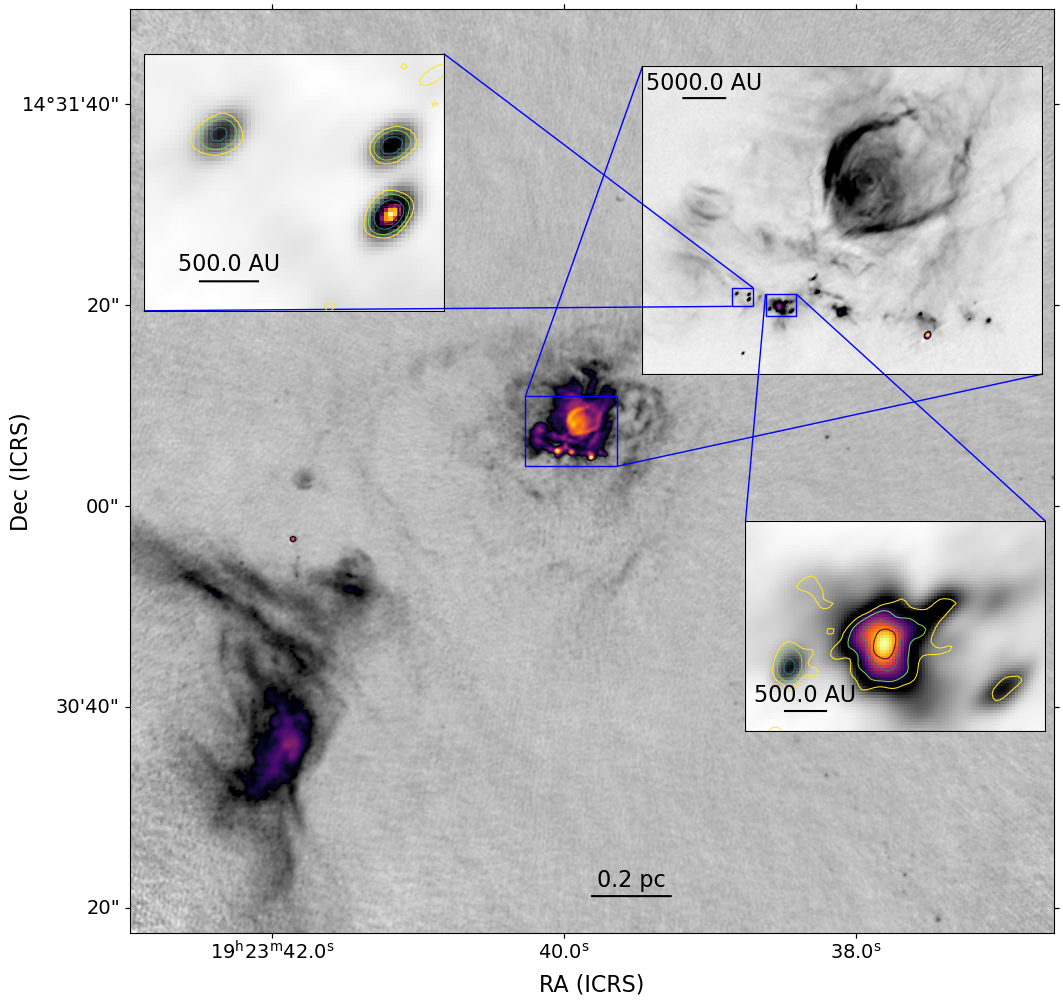

In [26]:
tick_fontsize = 14
fontsize = 16
cutout = slice(1000,2840)

fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(projection=ww.celestial[cutout,cutout])
norm = visualization.simple_norm(fh[0].data.squeeze()[cutout,cutout], stretch='linear', max_percent=99.)
im = ax.imshow(fh[0].data.squeeze()[cutout,cutout], cmap='gray_r',
               norm=norm)


cm = copy.copy(pl.cm.get_cmap('inferno'))
cm.set_under((0,0,0,0))

vmin = norm.vmax*0.9
norm2 = simple_norm(fh[0].data.squeeze()[cutout,cutout], min_cut=vmin, stretch='asinh', max_percent=99.9995)
norm2.vmin = vmin

ax.imshow(fh[0].data.squeeze()[cutout,cutout], norm=norm2, cmap=cm)

radesys = ww.wcs.radesys
_ = ax.set_xlabel(f"Right Ascension {radesys}")
_ = ax.set_ylabel(f"Declination {radesys}")

distance = 5.1*u.kpc
img = fh[0].data.squeeze()[cutout,cutout]
scalebar_length = 0.2*u.pc
scalebar_loc=(0.04,0.5) # y, x
left_side = coordinates.SkyCoord(*ww.celestial[cutout,cutout].wcs_pix2world(scalebar_loc[1]*img.shape[1],
                                                             scalebar_loc[0]*img.shape[0], 0)*u.deg,
                                 frame=radesys.lower())

length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
make_scalebar(ax, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
              text_offset=0.5*u.arcsec, fontsize=fontsize)


ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticklabel(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticklabel(exclude_overlapping=True)

pl.savefig('W51_IRS2_almaimf_parent.png', bbox_inches='tight')


# W51 IRS2
axins3 = inset_axes(ax,
                   loc=1, width=4, height=4,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww_lb))
ww4 = ww_lb
xl,xr = 6700,8000
yl,yr = 7100,8100
bl = coordinates.SkyCoord(*ww4.wcs_pix2world(xl, yl, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww4.wcs_pix2world(xr, yr, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
inset_norm = simple_norm(im4[yl:yr,xl:xr], stretch='linear', max_percent=99.)              
axins3.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap='gray_r',
              norm=inset_norm
             )

vmin = norm.vmax*0.9
inset_norm2 = simple_norm(im4[yl:yr,xl:xr], min_cut=vmin, stretch='asinh', max_percent=99.9995)
inset_norm2.vmin = vmin

axins3.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap=cm,
              norm=inset_norm2,
             )

mark_inset_otherdata(axins3, ax, bl, tr, 2, 4,)
hide_ticks(axins3)

scalebar_length = 5000*u.au
length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
left_side = coordinates.SkyCoord(*ww4.wcs_pix2world(xl+130, yl+900, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
make_scalebar(axins3, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
              text_offset=0.1*u.arcsec, fontsize=fontsize)


pl.savefig('W51_IRS2_almaimf_lb_zoom.png', bbox_inches='tight')



axins3b = inset_axes(axins3,
                   loc=2, width=3, height=3,
                   bbox_to_anchor=(0.13, 0.0,1,0.87),
                    bbox_transform=fig.transFigure,                    
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww_lb))
ww4 = ww_lb
xl,xr = 6990,7060
yl,yr = 7320,7380
bl = coordinates.SkyCoord(*ww4.wcs_pix2world(xl, yl, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww4.wcs_pix2world(xr, yr, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
inset_norm = simple_norm(im4[yl:yr,xl:xr], stretch='linear', max_percent=99.)              
axins3b.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap='gray_r',
              norm=inset_norm
             )

vmin = norm.vmax*0.9
inset_norm2 = simple_norm(im4[yl:yr,xl:xr], min_cut=vmin, stretch='linear', max_percent=99.9995)
inset_norm2.vmin = vmin

axins3b.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap=cm,
              norm=inset_norm2,
             )

mark_inset_otherdata(axins3b, axins3, bl, tr, 1, 3,)
hide_ticks(axins3b)

scalebar_length = 500*u.au
length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
left_side = coordinates.SkyCoord(*ww4.wcs_pix2world(xl+10, yl+10, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
make_scalebar(axins3b, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
              text_offset=0.01*u.arcsec, fontsize=fontsize)

axins3c = inset_axes(axins3,
                   loc=1, width=3, height=3,
                   bbox_to_anchor=(0.0, 0.0, 0.9,0.5),
                    bbox_transform=fig.transFigure,                    
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww_lb))
ww4 = ww_lb
xl,xr = 7100,7200
yl,yr = 7290,7360
bl = coordinates.SkyCoord(*ww4.wcs_pix2world(xl, yl, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww4.wcs_pix2world(xr, yr, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
inset_norm = simple_norm(im4[yl:yr,xl:xr], stretch='linear', max_percent=90.)              
axins3c.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap='gray_r',
              norm=inset_norm
             )

vmin = norm.vmax*0.99
inset_norm2 = simple_norm(im4[yl:yr,xl:xr], min_cut=vmin, stretch='linear', max_percent=99.9995)
inset_norm2.vmin = vmin

axins3c.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap=cm,
              norm=inset_norm2, 
             )

mark_inset_otherdata(axins3c, axins3, bl, tr, 1, 2,)
hide_ticks(axins3c)

scalebar_length = 500*u.au
length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
left_side = coordinates.SkyCoord(*ww4.wcs_pix2world(xl+10, yl+10, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
make_scalebar(axins3c, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
              text_offset=0.01*u.arcsec, fontsize=fontsize)


pl.savefig('W51_IRS2_almaimf_lb_rezoom.png', bbox_inches='tight')



cen = w51irs2qband.shape[1]/2, w51irs2qband.shape[2]/2
qcut = w51irs2qband[:,cen[0]-300:cen[0]+500, cen[1]-300:cen[1]+500][0]
qww = qcut.wcs.celestial
# I hope this is the difference between ICRS and FK5...
qww.wcs.crval += 0.02 / 3600.

axins3c.contour(qcut.value, transform=axins3c.get_transform(qww), levels=[0.00005, 0.0001, 0.0002, 0.0003], cmap='viridis_r', linewidths=0.75)
axins3b.contour(qcut.value, transform=axins3b.get_transform(qww), levels=[0.00005, 0.0001, 0.0002, 0.0003], cmap='viridis_r', linewidths=0.75)
#axins3.contour(qcut.value, transform=axins3.get_transform(qww), levels=[0.0002, 0.0005], colors=['r','r'], linewidths=0.5)


pl.savefig('W51_IRS2_almaimf_lb_rezoom_vlaq.png', bbox_inches='tight')


In [27]:
qcut = w51irs2qband[:,cen[0]-300:cen[0]+500, cen[1]-300:cen[1]+500][0]

In [28]:
pwd

'/orange/adamginsburg/w51/2017.1.00293.S/may2021_imaging'

In [29]:
ls -lh ../../vla/16B-202_W51QKa/FITS

total 245G
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  4  2017 2560_W51e2w_QbandAarray_cont_spws_continuum_cal_clean_2terms.pb.fits
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  4  2017 2560_W51e2w_QbandAarray_cont_spws_continuum_cal_clean_2terms.residual.fits
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  4  2017 2560_W51e2w_QbandAarray_cont_spws_continuum_cal_clean_natural.pb.fits
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  4  2017 2560_W51e2w_QbandAarray_cont_spws_continuum_cal_clean_natural.residual.fits
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  3  2017 2560_W51e2w_QbandAarray_cont_spws_raw_continuum_cal_clean.pb.fits
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  3  2017 2560_W51e2w_QbandAarray_cont_spws_raw_continuum_cal_clean.residual.fits
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  4  2017 2560_W51North_QbandAarray_cont_spws_continuum_cal_clean_2terms.pb.fits
-rw-r--r-- 1 adamginsburg adamginsburg  26M Jan  4  2017 2560_W51North_QbandAarray_cont_spw

In [30]:
from astropy import coordinates, units as u
from astropy.io import fits

In [31]:
ch3ocho = fits.open('/orange/adamginsburg/w51/2013.1.00308.S/FITS/chemslices/chemical_max_slabs_north_CH3OCHO17314-16313E.fits')[0]

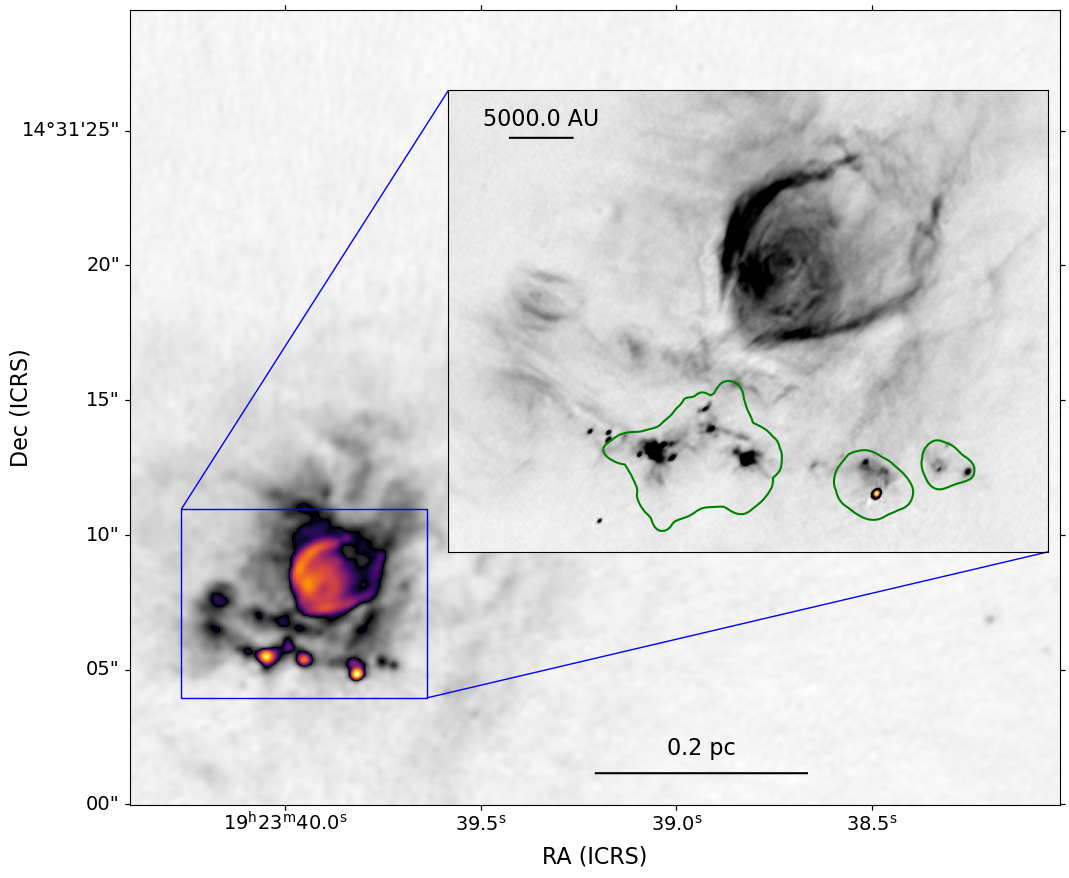

In [35]:
tick_fontsize = 14
fontsize = 16
cutout = slice(1850,2440), slice(1750,2440)

fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(projection=ww.celestial[cutout])
norm = visualization.simple_norm(fh[0].data.squeeze()[cutout], stretch='linear', max_percent=99.)
im = ax.imshow(fh[0].data.squeeze()[cutout], cmap='gray_r',
               norm=norm)


cm = copy.copy(pl.cm.get_cmap('inferno'))
cm.set_under((0,0,0,0))

vmin = norm.vmax*0.9
norm2 = simple_norm(fh[0].data.squeeze()[cutout], min_cut=vmin, stretch='asinh', max_percent=99.9995)
norm2.vmin = vmin

ax.imshow(fh[0].data.squeeze()[cutout], norm=norm2, cmap=cm)

radesys = ww.wcs.radesys
_ = ax.set_xlabel(f"Right Ascension {radesys}")
_ = ax.set_ylabel(f"Declination {radesys}")

distance = 5.1*u.kpc
img = fh[0].data.squeeze()[cutout]
scalebar_length = 0.2*u.pc
scalebar_loc=(0.04,0.5) # y, x
left_side = coordinates.SkyCoord(*ww.celestial[cutout].wcs_pix2world(scalebar_loc[1]*img.shape[1],
                                                             scalebar_loc[0]*img.shape[0], 0)*u.deg,
                                 frame=radesys.lower())

length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
make_scalebar(ax, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
              text_offset=0.5*u.arcsec, fontsize=fontsize)


ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticklabel(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticklabel(exclude_overlapping=True)


# W51 IRS2
axins3 = inset_axes(ax,
                   loc=1, width=6, height=6,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww_lb))
ww4 = ww_lb
xl,xr = 6700,8000
yl,yr = 7100,8100
bl = coordinates.SkyCoord(*ww4.wcs_pix2world(xl, yl, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww4.wcs_pix2world(xr, yr, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
inset_norm = simple_norm(im4[yl:yr,xl:xr], stretch='linear', max_percent=99.)              
axins3.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap='gray_r',
              norm=inset_norm
             )

vmin = norm.vmax*0.9
inset_norm2 = simple_norm(im4[yl:yr,xl:xr], min_cut=vmin, stretch='asinh', max_percent=99.9995)
inset_norm2.vmin = vmin

axins3.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap=cm,
              norm=inset_norm2, 
             )

mark_inset_otherdata(axins3, ax, bl, tr, 2, 4,)
hide_ticks(axins3)

scalebar_length = 5000*u.au
length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
left_side = coordinates.SkyCoord(*ww4.wcs_pix2world(xl+130, yl+900, 0), frame=ww4.wcs.radesys.lower(), unit=(u.deg,u.deg))
make_scalebar(axins3, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
              text_offset=0.1*u.arcsec, fontsize=fontsize)



axins3.contour(ch3ocho.data, levels=[40], colors=['g'], transform=axins3.get_transform(WCS(ch3ocho.header)))
#ax.contour(ch3ocho.data, levels=[30,60,90,120], colors=['g'], transform=ax.get_transform(WCS(ch3ocho.header)))
pl.savefig('W51-IRS2_almaimf_lb_zoom_ch3ochocontour.png', bbox_inches='tight')

In [36]:
pwd

'/orange/adamginsburg/w51/2017.1.00293.S/may2021_imaging'